In [1]:
%run utils
import utils

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skimage import io
from tqdm import trange, tqdm
import seaborn as sns
import os

In [3]:
TEST_FILE = "data/splits/val_inference_both.csv"
training_both = "data/splits/training_set_naip_nlcd_both.csv"
val_both = "data/splits/val_inference_both.csv"
IMAGE_COL = "image_fn"
LABEL_COL = "label_fn"
GROUP_COL = "gropu"
ROW = 3

### What are the dimensions of NAIP/NLCD image?

In [4]:
df = pd.read_csv(TEST_FILE)
a = io.imread(df.loc[3, LABEL_COL])
a.shape

(3880, 3880)

In [5]:
df = pd.read_csv(TEST_FILE)
a = io.imread(df.loc[3, IMAGE_COL])
a.shape

(3880, 3880, 4)

### Are validation images also in the training set?

In [6]:
training_both_df = pd.read_csv(training_both)
val_both_df = pd.read_csv(val_both)
print(f"There are {len(training_both_df)} samples in the training set")
print(f"There are {len(val_both_df)} samples in the val set")

There are 4500 samples in the training set
There are 100 samples in the val set


In [7]:
all_in = True
for i in range(len(val_both_df)):
    if val_both_df.loc[i, "image_fn"] not in training_both_df["image_fn"].tolist():
        print(val_both_df.loc[i, "image_fn"])
        all_in = False
        break
    elif val_both_df.loc[i, "label_fn"] not in training_both_df["label_fn"].tolist():
        print(val_both_df.loc[i, "image_fn"])
        all_in = False
        break
all_in

True

### Reading geojson

In [8]:
import geopandas

In [9]:
# the labels annotated by Masa for 3716_naip-2013
gdf = geopandas.read_file("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
gdf.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-76.45065 38.23535, -76.45041 ..."
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-76.42804 38.23022, -76.42678 ..."


In [10]:
gdf['default'].unique()

array(['Impervious', 'Tree Canopy', 'Low Vegetation', 'Water'],
      dtype=object)

In [11]:
gdf.shape

(123, 7)

In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'WGS84 (lat/lon)')

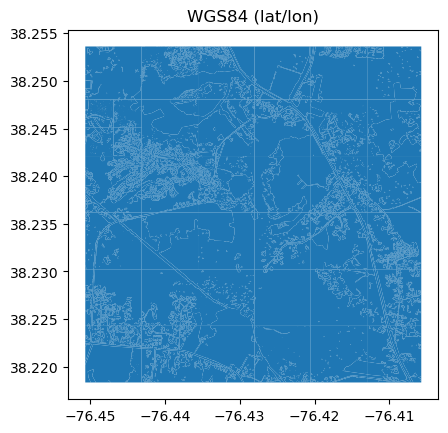

In [13]:
ax = gdf.plot()
ax.set_title("WGS84 (lat/lon)")

<AxesSubplot: >

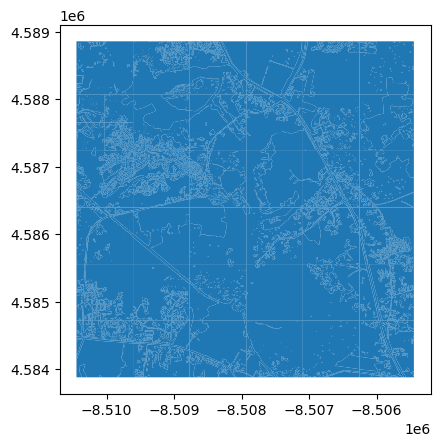

In [14]:
# reproject the original degree-based projection to Mercator
gdf = gdf.to_crs("EPSG:3395")
gdf.plot()

In [15]:
# add an area column
# the area should be in square meters
gdf['area (sq meters)'] = gdf.area
gdf.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry,area (sq meters)
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-8510447.251 4586277.893, -851...",31774.809832
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-8507930.673 4585554.896, -850...",550702.822286


In [16]:
# compute the area percentage of all 4 classes
total_area = gdf['area (sq meters)'].sum()
all_classes = gdf['default'].unique()
percentages = []
for c in all_classes:
    gdf_sub = gdf.loc[gdf['default'] == c]
    sub_class_area_perc = gdf_sub['area (sq meters)'].sum() / total_area
    percentages.append(sub_class_area_perc)

Text(0.5, 1.0, 'Area Percentage of 4 Classes in 3716_naip-2013')

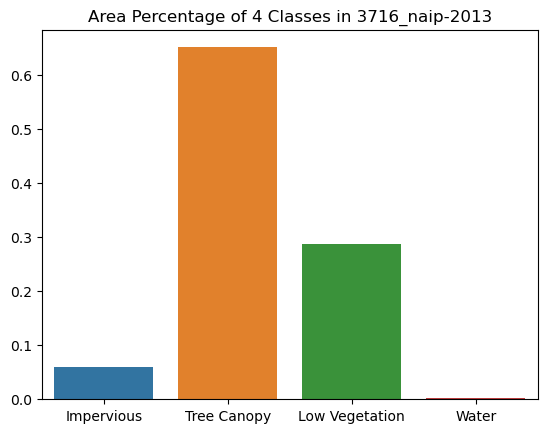

In [17]:
# plot
ax = sns.barplot(x=all_classes, y=percentages)
ax.set_title("Area Percentage of 4 Classes in 3716_naip-2013")

In [18]:
def get_percentages(geojson_path) -> dict:
    gdf = geopandas.read_file(geojson_path)
    gdf = gdf.to_crs("EPSG:3395")
    gdf["area (sq meters)"] = gdf.area
    total_area = gdf['area (sq meters)'].sum()
    all_classes = gdf['default'].unique()
    res = {}
    for c in all_classes:
        gdf_sub = gdf.loc[gdf['default'] == c]
        sub_class_area_perc = gdf_sub['area (sq meters)'].sum() / total_area
        res[c] = sub_class_area_perc
    return res

In [19]:
def get_reduced_class_names(nlcd_label_int) -> str:
    assert nlcd_label_int in utils.NLCD_CLASS.keys()
    for k, v in utils.MAPPING.items():
        if nlcd_label_int in v:
            return k

In [20]:
def create_direct_map():
    res = {}
    for k in utils.NLCD_CLASS.keys():
        for m, n in utils.MAPPING.items():
            if k in n:
                res[k] = m
    return res

In [21]:
def find_image_index(df, image_number, year, col):
    for i in range(len(df)):
        if f"{image_number}_nlcd-{year}" in df.loc[i, col]:
            return i

In [22]:
def calculate_class_percentages(df, image_number, year, col, res) -> dict:
    """Calculate class percentage
    
    Args:
        df: training_both_df
        image_number: str or int, e.g. 3716
        year: str or int, e.g. 2013
        col: str, e.g. "label_fn"
        res: int, e.g. 30 means 30 x 30
    
    Returns:
        dict
    """
    img_index = find_image_index(df, image_number, year, col)
    img = io.imread(df.loc[img_index, col])
    perc_dict = {}
    for m in trange(img.shape[0], desc="1st loop"):
        for n in range(img.shape[1]):
            # "Tree Canopy" / "Water" / ...
            class_label = reduced_map[img[m][n]]
            perc_dict[class_label] = perc_dict.get(class_label, 0) + res ** 2
    for k, v in perc_dict.items():
        perc_dict[k] = v / (img.shape[0] * img.shape[1] * res ** 2)
    return perc_dict

In [23]:
training_both_df = pd.read_csv("data/splits/training_set_naip_nlcd_both.csv")
reduced_map = create_direct_map()

In [24]:
nlcd_percentage_3716_2013 = calculate_class_percentages(training_both_df, "3716", "2013", "label_fn", 30)
nlcd_percentage_3716_2016 = calculate_class_percentages(training_both_df, "3716", "2016", "label_fn", 30)

1st loop: 100%|███████████████████████████████████████████████████████████████████████████| 3880/3880 [00:37<00:00, 102.20it/s]


In [25]:
masa_annotated_3716_2013 = get_percentages("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
masa_annotated_3716_2017 = get_percentages("data/catalog/labels/data/a4d9c2f2-c09a-4515-b061-4bb854cb4c44.geojson")

In [26]:
masa_annotated_3716_2013

{'Impervious': 0.05906276881854651,
 'Tree Canopy': 0.6514570110188175,
 'Low Vegetation': 0.28749929564818527,
 'Water': 0.0019809245144506906}

In [27]:
masa_annotated_3716_2017

{'Tree Canopy': 0.6814331121402595,
 'Impervious': 0.05798948817612803,
 'Low Vegetation': 0.25860959215561624,
 'Water': 0.00196780752799619}

In [28]:
nlcd_percentage_3716_2013

{'Tree Canopy': 0.6943465033478584,
 'Low Vegetation': 0.23974080667446063,
 'Impervious': 0.06509445743437135,
 'Water': 0.0008182325433095972}

In [29]:
nlcd_percentage_3716_2016

{'Tree Canopy': 0.6815032814326708,
 'Low Vegetation': 0.25148308800085023,
 'Impervious': 0.0662537198427038,
 'Water': 0.0007599107237751089}

In [108]:
def plot_bars(nlcd_annotation, masa_annotation, image_number, year):
    df = pd.DataFrame.from_records([nlcd_annotation, masa_annotation], 
                                    index=["NLCD", "high-res"])
    df = df.reset_index().rename(columns={"index": "Annotation"})
    df = df.melt(id_vars=["Annotation"], 
                 value_vars=["Tree Canopy", "Low Vegetation", "Impervious", "Water"], 
                 var_name="Class", value_name="Percentage")
    df["Percentage"] = df["Percentage"] * 100
    # round to 4 decimal places
    df = df.round({"Percentage": 4})
    ax = sns.barplot(data=df, x="Class", y="Percentage", hue="Annotation")
    ax.set_title(f"NLCD vs. High-resolution Annotation in {image_number} NAIP, {year}")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    # add texts above bars
    ax.bar_label(ax.containers[0], fontsize=9)
    ax.bar_label(ax.containers[1], fontsize=9)
    # iterate over the texts and format to percentages
    for t in ax.texts: 
        t.set_text(f"{round(float(t.get_text()), 2)}%")
    plt.savefig(f"{image_number}_naip-{year}.png",bbox_inches='tight')

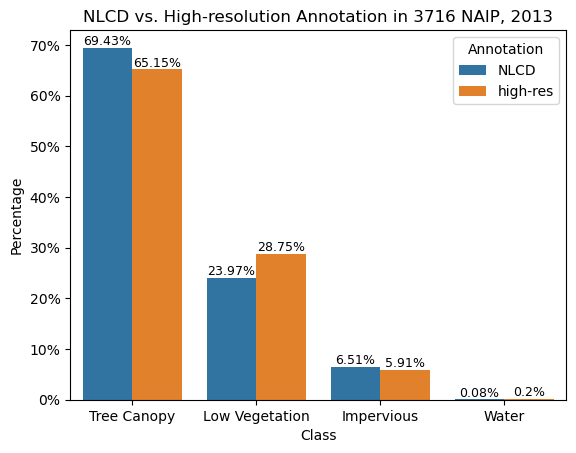

In [109]:
plot_bars(nlcd_percentage_3716_2013, masa_annotated_3716_2013, "3716", "2013")

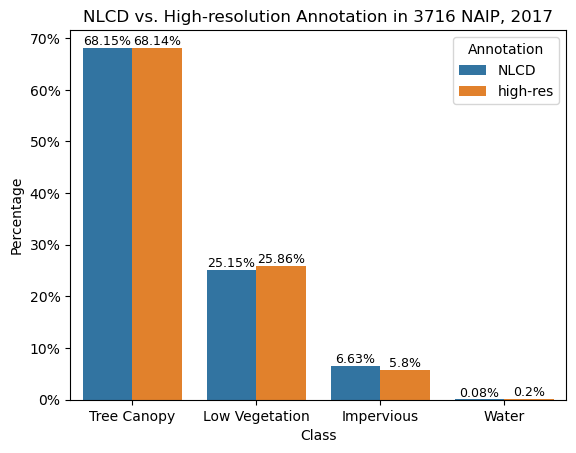

In [110]:
plot_bars(nlcd_percentage_3716_2016, masa_annotated_3716_2017, "3716", "2017")

### Heatmaps

In [169]:
REDUCED_CLASSES = ["Water", "Tree Canopy", "Low Vegetation", "Impervious"]

In [113]:
reduced_map

{0: 'No Data',
 11: 'Water',
 12: 'No Data',
 21: 'Low Vegetation',
 22: 'Impervious',
 23: 'Impervious',
 24: 'Impervious',
 31: 'Impervious',
 41: 'Tree Canopy',
 42: 'Tree Canopy',
 43: 'Tree Canopy',
 52: 'Tree Canopy',
 71: 'Low Vegetation',
 81: 'Low Vegetation',
 82: 'Low Vegetation',
 90: 'Tree Canopy',
 95: 'Tree Canopy'}

In [116]:
# NLCD images as np.ndarrays with image number 3716
img_NLCD_2016_index = find_image_index(training_both_df, 3716, 2016, "label_fn")
img_NLCD_2013_index = find_image_index(training_both_df, 3716, 2013, "label_fn")
img_NLCD_2016 = io.imread(training_both_df.loc[img_2016_index, 'label_fn'])
img_NLCD_2013 = io.imread(training_both_df.loc[img_2013_index, 'label_fn'])

In [114]:
def find_distribution_change(img_2013, img_2016, reduced_map: dict) -> dict:
    distribution_change = {k: {m: 0 for m in REDUCED_CLASSES} for k in REDUCED_CLASSES}
    for i in trange(img_2013.shape[0]):
        for j in range(img_2013.shape[1]):
            label_2013 = reduced_map[img_2013[i][j]]
            label_2016 = reduced_map[img_2016[i][j]]
            distribution_change[label_2013][label_2016] += 1
    # change to percentage
    for k in distribution_change.keys():
        sum_value = sum(distribution_change[k].values())
        for m in distribution_change[k].keys():
            distribution_change[k][m] /= sum_value
    
    return distribution_change

In [117]:
distribution_change_NLCD_3716 = find_distribution_change(img_NLCD_2013, img_NLCD_2016, reduced_map)

100%|██████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [01:06<00:00, 58.57it/s]


In [145]:
def plot_heatmaps(percentage_map_2013: dict, distribution_change: dict, 
                  title: str, xlabel: str, ylabel: str, figname: str) -> None:
    """Plot heatmaps of class distributions in 2013 vs 2017 and save the image. """
    index_col = []
    for c in REDUCED_CLASSES:
        index_col.append(f"{c} ({percentage_map_2013[c] * 100:.2f}%)")

    # construct df by rows, make sure the order is right by 
    # iterating through REDUCED_CLASSES
    heatmap_df = pd.DataFrame.from_records(data=[{m: distribution_change[k][m] for m in REDUCED_CLASSES} for k in REDUCED_CLASSES], 
                                           index=index_col)
    heatmap_df = heatmap_df * 100
    heatmap_df = heatmap_df.round(1)
    
    # plot heatmap
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu")
    # set the colorbar to percentage format
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # iterate over the texts and format to percentages
    for t in ax.texts: 
        t.set_text(f"{float(t.get_text())}%")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig(figname, bbox_inches='tight')

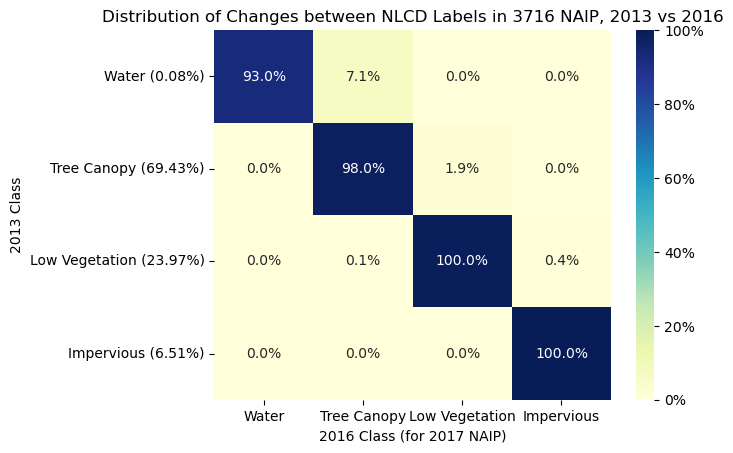

In [170]:
plot_heatmaps(nlcd_percentage_3716_2013, distribution_change_NLCD_3716, 
              title="Distribution of Changes between NLCD Labels in 3716 NAIP, 2013 vs 2016",
              xlabel="2016 Class (for 2017 NAIP)",
              ylabel="2013 Class", 
              figname="Distribution of Changes between NLCD Labels in 3716 NAIP, 2013 vs 2016.png")

In [153]:
def calculate_class_percentages_diff_pixels(img_ndarray_2013, img_ndarray_2016, mapping: dict):
    perc_dict = {k: 0 for k in REDUCED_CLASSES}
    for m in trange(img_ndarray_2013.shape[0], desc="1st loop"):
        for n in range(img_ndarray_2013.shape[1]):
            class_label_2013 = mapping[img_ndarray_2013[m][n]]
            class_label_2016 = mapping[img_ndarray_2016[m][n]]
            if class_label_2013 != class_label_2016:
                perc_dict[class_label_2013] += 1
    sum_value = sum(perc_dict.values())
    for k, v in perc_dict.items():
        perc_dict[k] = v / sum_value
    return perc_dict

In [154]:
nlcd_percentage_3716_2013_diff_pixels = calculate_class_percentages_diff_pixels(img_NLCD_2013, img_NLCD_2016, reduced_map)

1st loop: 100%|████████████████████████████████████████████████████████████████████████████| 3880/3880 [01:04<00:00, 60.11it/s]


In [164]:
def find_distribution_change_for_diff_pixels(img_2013, img_2016, mapping: dict) -> dict:
    distribution_change = {k: {m: 0 for m in REDUCED_CLASSES} for k in REDUCED_CLASSES}
    for i in trange(img_2013.shape[0]):
        for j in range(img_2013.shape[1]):
            label_2013 = mapping[img_2013[i][j]]
            label_2016 = mapping[img_2016[i][j]]
            # only restricted to pixels whose labels are different
            if label_2013 != label_2016:
                distribution_change[label_2013][label_2016] += 1
                
    # change to percentage
    for k in distribution_change.keys():
        # excluding the value itself
        sum_value = sum(distribution_change[k].values()) - distribution_change[k][k]
        for m in distribution_change[k].keys():
            if sum_value == 0:
                distribution_change[k][m] = 0
            else:
                distribution_change[k][m] /= sum_value
    
    return distribution_change

In [127]:
distribution_change_NLCD_3716_diff_pixels = find_distribution_change_for_diff_pixels(img_NLCD_2013, img_NLCD_2016, reduced_map)

100%|██████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [01:06<00:00, 58.63it/s]


In [159]:
def plot_heatmaps_no_diagonal(percentage_map_2013: dict, distribution_change: dict, 
                              title: str, xlabel: str, ylabel: str, figname: str) -> None:
    # construct the index column
    index_col = []
    for c in REDUCED_CLASSES:
        index_col.append(f"{c} ({percentage_map_2013[c] * 100:.2f}%)")
        
    heatmap_df = pd.DataFrame.from_records(data=[{m: distribution_change[k][m] for m in REDUCED_CLASSES} for k in REDUCED_CLASSES], 
                                           index=index_col)
    heatmap_df = heatmap_df * 100
    heatmap_df = heatmap_df.round(1)
    
    # plot heatmap
    mask = np.eye(len(heatmap_df))
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", mask=mask)
    # set the colorbar to percentage format
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # iterate over the texts and format to percentages
    for t in ax.texts: 
        t.set_text(f"{float(t.get_text())}%")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig(figname, bbox_inches='tight')

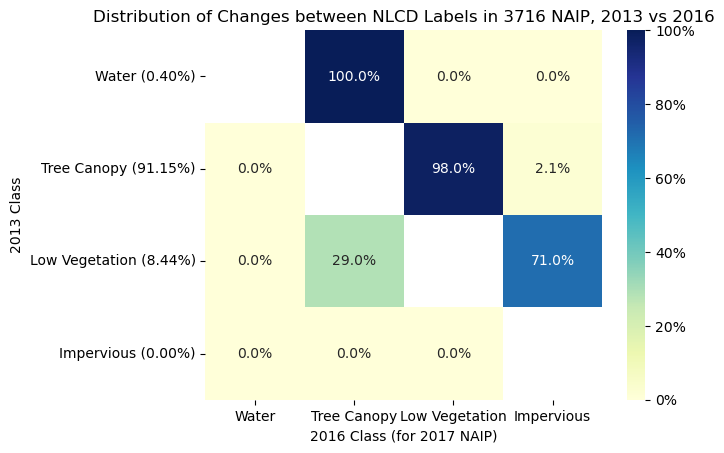

In [171]:
plot_heatmaps_no_diagonal(nlcd_percentage_3716_2013_diff_pixels, distribution_change_NLCD_3716_diff_pixels,
                          title="Distribution of Changes between NLCD Labels in 3716 NAIP, 2013 vs 2016",
                          xlabel="2016 Class (for 2017 NAIP)",
                          ylabel="2013 Class",
                          figname="Distribution of Changes between NLCD Labels in 3716 NAIP, 2013 vs 2016 (2).png")

### Compare distributions of high-res annotations

X and Y-coordinates are longitude and latitude respectively 
mapXmin:  -76.4506484 
mapXmax:  -76.4057326 
mapYmin:  38.2183346 
mapYmax:  38.25361459999999 

from corresponding NLCD 
mapXmin:  -76.45056472222223 
mapXmax:  -76.40557333333334 
mapYmin:  38.218333333333334 
mapYmax:  38.25361138888889 
Note that it seems to be better to use the one from the exported high-res label from GroundWork 

W: 0.044915800000012496 
H: 0.035279999999993095
pixel_size_x: 1.1576237113405283e-05 
pixel_size_y: 9.092783505152859e-06

size of image: (3880, 3880) 
size of image_gray: (3880, 3880) 
size of image -- rbg: (3880, 3880, 3) as numpy array 
size of image_gray -- gray-scale: (3880, 3880) as numpy array

---Distribution------------------- 
0: Water 
1: Tree Canopy 
2: Low Vegetation 
3: Impervious

 1    9714703
2    4369524
3     940036
0      30137
dtype: int64


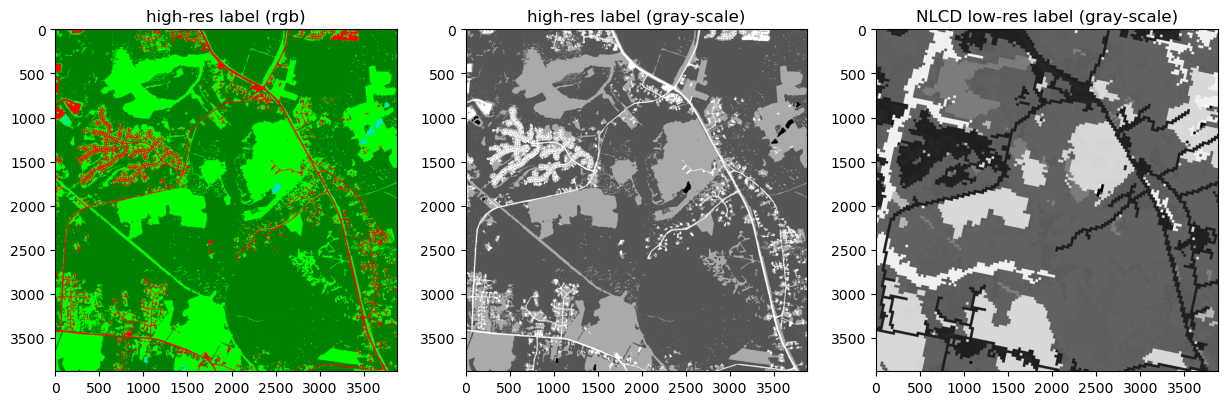

In [2]:
store_np_and_png(nlcd_path = 'data/3716_nlcd-2016.tif', # File path of the downloaded NLCD image
                 hr_label_path = 'data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson',
                 # File path of the exported label (/catalog/labels/data/xxx.geojson) from GroundWork
                 output_path = "data/", image_id_year = "3716_2013")

In [46]:
# read npy
image_3716_2013_np = np.load('data/2013/image_gray-3716_2013.npy')
image_3716_2016_np = np.load('data/2016/image_gray-3716_2016.npy')
CLASS_MAPPING = {
    0: "Water",
    1: "Tree Canopy",
    2: "Low Vegetation",
    3: "Impervious"
}

In [47]:
def calculate_percentages_from_numpy(img_array):
    res = {}
    for i in range(len(img_array)):
        for j in range(len(img_array[0])):
            res[img_array[i][j]] = res.get(img_array[i][j], 0) + 1
    sum_values = sum(res.values())
    for k in res.keys():
        res[k] /= sum_values
    return {CLASS_MAPPING[k]: v for k, v in res.items()}

In [48]:
image_3716_2013_percentages = calculate_percentages_from_numpy(image_3716_2013_np)
image_3716_2016_percentages = calculate_percentages_from_numpy(image_3716_2016_np)

In [142]:
distribution_change_highres = find_distribution_change(image_3716_2013_np, image_3716_2016_np, CLASS_MAPPING)

100%|██████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [01:02<00:00, 62.11it/s]


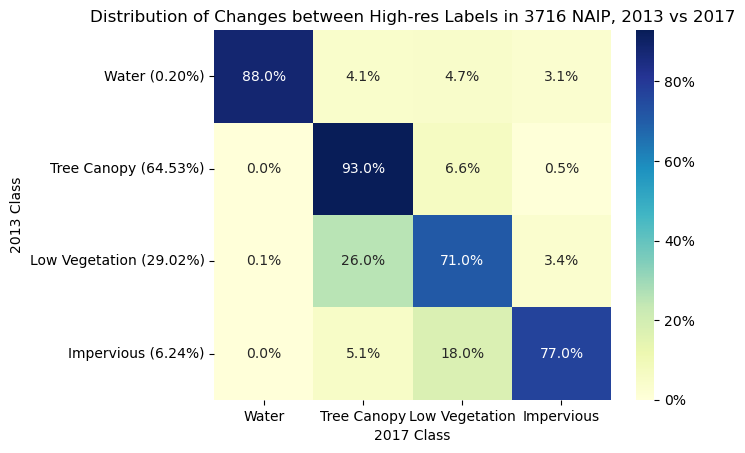

In [172]:
plot_heatmaps(image_3716_2013_percentages, distribution_change_highres, 
              title="Distribution of Changes between High-res Labels in 3716 NAIP, 2013 vs 2017",
              xlabel="2017 Class",
              ylabel="2013 Class", 
              figname="Distribution of Changes between NLCD Labels in 3716 NAIP, 2013 vs 2017.png")

In [165]:
percentages_highres_2013_diff_pixels = calculate_class_percentages_diff_pixels(image_3716_2013_np, image_3716_2016_np, CLASS_MAPPING)

1st loop: 100%|████████████████████████████████████████████████████████████████████████████| 3880/3880 [00:57<00:00, 67.65it/s]


In [167]:
distribution_change_highres_diff = find_distribution_change_for_diff_pixels(image_3716_2013_np, image_3716_2016_np, CLASS_MAPPING)

100%|██████████████████████████████████████████████████████████████████████████████████████| 3880/3880 [00:59<00:00, 65.15it/s]


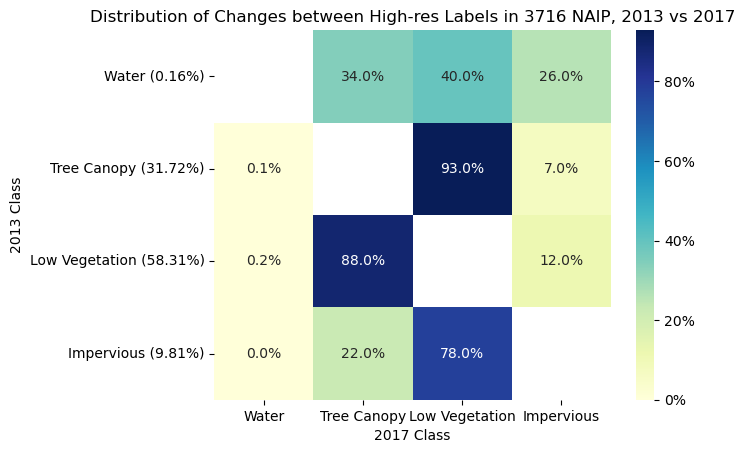

In [173]:
plot_heatmaps_no_diagonal(percentages_highres_2013_diff_pixels, distribution_change_highres_diff,
                          title="Distribution of Changes between High-res Labels in 3716 NAIP, 2013 vs 2017",
                          xlabel="2017 Class",
                          ylabel="2013 Class",
                          figname="Distribution of Changes between NLCD Labels in 3716 NAIP, 2013 vs 2017 (2).png")